In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Imports
from os.path import join
from os import makedirs
import numpy as np
import sys

rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.cluster.hierarchy import linkage, dendrogram
from hdbscan import HDBSCAN

sys.path.append("..")
from vis_utils import configure_plotting_for_thesis

configure_plotting_for_thesis()

Plots configured for thesis!


<IPython.core.display.Javascript object>

In [3]:
# Constants
output_dir = "output_plots"
makedirs(output_dir, exist_ok=True)
save_plots_to_file = True

<IPython.core.display.Javascript object>

## Linear regression

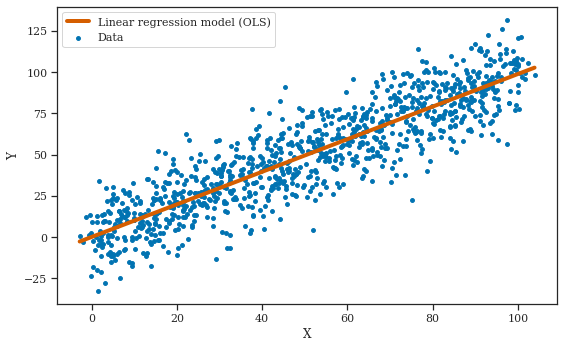

<IPython.core.display.Javascript object>

In [4]:
# Create data
lin_reg_data_x = np.linspace(0, 100, 1000) + np.random.normal(size=1000, scale=2)
lin_reg_data_x_mat = np.array((np.ones_like(lin_reg_data_x), lin_reg_data_x)).T
lin_reg_data_y = lin_reg_data_x + np.random.normal(size=1000, scale=15)

# Plot data
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.scatter(x=lin_reg_data_x, y=lin_reg_data_y, label="Data", c="b", s=15)

# Compute best OLS fit and plot it
[ols_int, ols_slope] = (
    np.linalg.inv(lin_reg_data_x_mat.T @ lin_reg_data_x_mat)
    @ lin_reg_data_x_mat.T
    @ lin_reg_data_y
)
xs = np.linspace(lin_reg_data_x.min(), lin_reg_data_x.max(), 1000)
ax.plot(
    xs,
    ols_int + ols_slope * xs,
    label="Linear regression model (OLS)",
    linewidth=4,
    c="r",
)

# Plot/save
plt.tight_layout()
plt.legend()
if save_plots_to_file:
    plt.savefig(join(output_dir, "linear-regression-example.pdf"), backend="pgf")
else:
    plt.show()

## Logistic regression

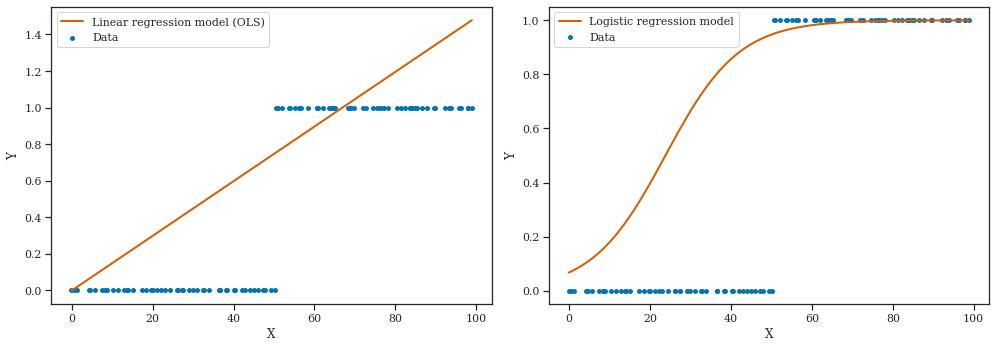

<IPython.core.display.Javascript object>

In [5]:
# Create data
log_reg_data_x = np.concatenate(
    (
        np.linspace(0, 50, 50) + np.random.normal(size=50, scale=1),
        np.linspace(50, 100, 50) + np.random.normal(size=50, scale=1),
    )
)
log_reg_data_x_mat = np.array((np.ones_like(log_reg_data_x), log_reg_data_x)).T
log_reg_data_y = np.concatenate((np.zeros(50, dtype=int), np.ones(50, dtype=int)))

# Compute linear and logistic regression models
lr_model = LinearRegression()
lr_model.fit(X=log_reg_data_x_mat, y=log_reg_data_y)
lr_int, lr_slope = lr_model.coef_
logr_model = LogisticRegression(solver="liblinear")
logr_model.fit(X=log_reg_data_x_mat, y=log_reg_data_y)
logr_int, logr_slope = logr_model.coef_[0]

# Plot linear vs. logistic regression line
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7 * 2, 5))
xs = np.linspace(log_reg_data_x.min(), log_reg_data_x.max(), 1000)
ax1.scatter(x=log_reg_data_x, y=log_reg_data_y, label="Data", s=15)
ax1.plot(
    xs,
    lr_int + lr_slope * xs,
    c="r",
    label="Linear regression model (OLS)",
    linewidth=2,
)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend()
ax2.scatter(x=log_reg_data_x, y=log_reg_data_y, label="Data", s=15)
ax2.plot(
    xs,
    (np.exp(logr_int + logr_slope * xs)) / (1 + np.exp(logr_int + logr_slope * xs)),
    c="r",
    label="Logistic regression model",
    linewidth=2,
)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.legend()

plt.tight_layout()
if save_plots_to_file:
    plt.savefig(join(output_dir, "logistic-regression-example.pdf"), backend="pgf")
else:
    plt.show()

## Plotting common activation functions

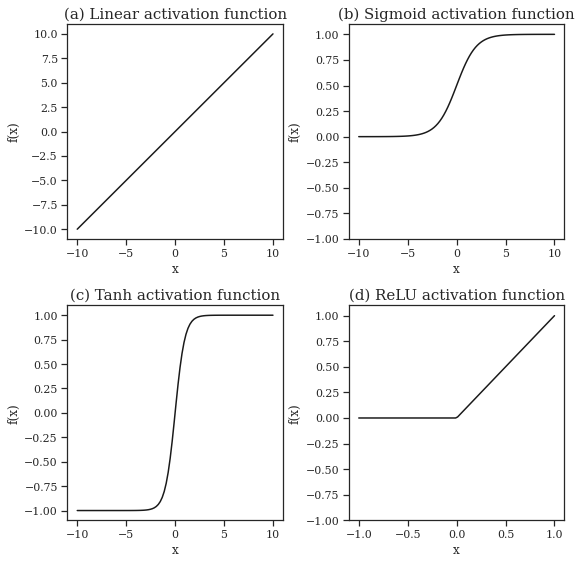

<IPython.core.display.Javascript object>

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
plot_params = {"c": "k"}
title_params = {"fontdict": {"fontsize": 15}}

# Linear activation function
xs = np.linspace(-10, 10, 100)
ax1.plot(xs, xs, **plot_params)
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.set_title("(a) Linear activation function", **title_params)

# Sigmoid activation function
sigmoid = lambda x: 1 / (1 + np.exp(-x))
ax2.set_ylim(-1, 1.1)
ax2.plot(xs, sigmoid(xs), **plot_params)
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.set_title("(b) Sigmoid activation function", **title_params)

# Tanh activation function
tanh = lambda x: (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
ax3.plot(xs, tanh(xs), **plot_params)
ax3.set_xlabel("x")
ax3.set_ylabel("f(x)")
ax3.set_title("(c) Tanh activation function", **title_params)

# ReLU activation function
xs = np.linspace(-1, 1, 100)
relu = lambda x: np.maximum(x, 0)
ax4.set_ylim(-1, 1.1)
ax4.plot(xs, relu(xs), **plot_params)
ax4.set_xlabel("x")
ax4.set_ylabel("f(x)")
ax4.set_title("(d) ReLU activation function", **title_params)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(join(output_dir, "common-activation-functions.pdf"), backend="pgf")
else:
    plt.show()

## Curse of dimensionality

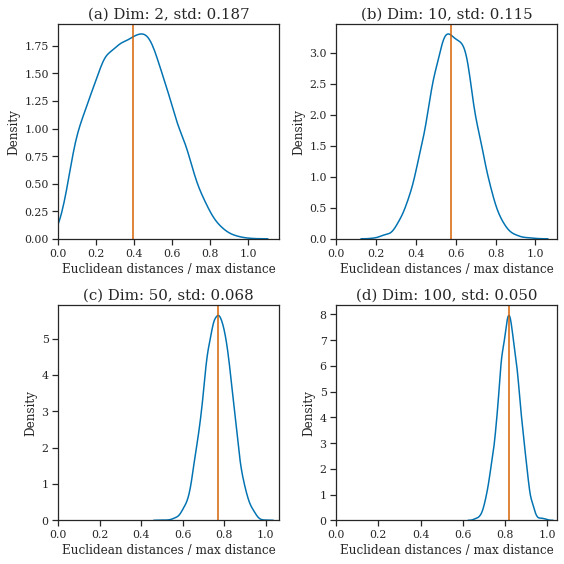

<IPython.core.display.Javascript object>

In [7]:
num_points = 100
cod_dims = [2, 10, 50, 100]
cod_dims_chars = "abcd"
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
)
title_params = {"fontdict": {"fontsize": 15}}
for dims, dim_char, ax in zip(cod_dims, cod_dims_chars, axes.ravel()):

    # Generate points
    points = np.zeros((num_points, dims))
    for dim in range(dims):
        points[:, dim] = np.random.uniform(low=0, high=100, size=num_points)

    # Compute pairwise distances
    points_pairwise_dists = pdist(points)
    points_pairwise_dists_norm = points_pairwise_dists / points_pairwise_dists.max()
    points_pairwise_dists_norm_mean = np.mean(points_pairwise_dists_norm)

    sns.kdeplot(points_pairwise_dists_norm, ax=ax)

    # ax.plot(np.histogram(points_pairwise_dists_norm, bins="auto")[0])
    ax.axvline(
        points_pairwise_dists_norm_mean,
        ymin=0,
        ymax=np.max(points_pairwise_dists_norm),
        c="r",
    )
    ax.set_title(
        f"({dim_char}) Dim: {dims}, std: {np.std(points_pairwise_dists_norm):0.3f}",
        **title_params,
    )
    ax.set_xlabel("Euclidean distances / max distance")
    ax.set_ylabel("Density")
    ax.set_xlim(left=0)
    # ax.legend([f"Mean of points={points_pairwise_dists_norm_mean:0.3f}", "100 uniformly distributed points"])

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(join(output_dir, "curse-of-dimensionality.pdf"), backend="pgf")
else:
    plt.show()

## Dendrogram example

In [8]:
# Load data
iris_data = load_iris()
iris_data_X = iris_data["data"]
iris_data_y = iris_data["target"]

<IPython.core.display.Javascript object>

In [9]:
# Subsample Iris data to 10 data points per category
iris_data_point_per_cat = 10
iris_data_point_categories = len(np.unique(iris_data_y))
iris_data_X_sub = np.zeros(
    (iris_data_point_per_cat * iris_data_point_categories, iris_data_X.shape[1])
)
iris_data_y_sub = np.zeros(
    iris_data_point_per_cat * iris_data_point_categories, dtype=int
)
for label_i in range(3):
    iris_data_point_indices = np.where(iris_data_y == label_i)[0][
        :iris_data_point_per_cat
    ]
    iris_data_X_sub[
        iris_data_point_per_cat * label_i : iris_data_point_per_cat * (label_i + 1)
    ] = iris_data_X[iris_data_point_indices]
    iris_data_y_sub[
        iris_data_point_per_cat * label_i : iris_data_point_per_cat * (label_i + 1)
    ] = iris_data_y[iris_data_point_indices]

<IPython.core.display.Javascript object>

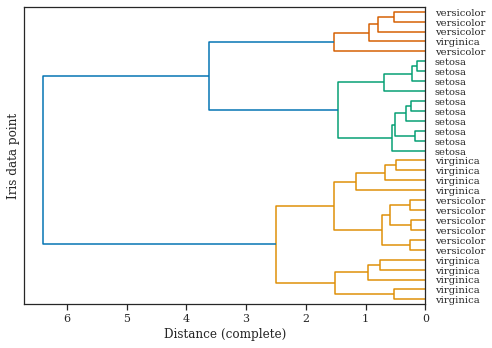

<IPython.core.display.Javascript object>

In [10]:
# Compute ward linkage on Iris data
iris_data_linkage = linkage(iris_data_X_sub, method="complete")
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Distance (complete)")
ax.set_ylabel("Iris data point")
dendrogram(
    Z=iris_data_linkage,
    labels=[iris_data["target_names"][y] for y in iris_data_y_sub],
    color_threshold=3,
    orientation="left",
    ax=ax,
)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(join(output_dir, "dendrogram-example.pdf"), backend="pgf")
else:
    plt.show()

# HDBSCAN example

In [11]:
# Load data
iris_data = load_iris()
iris_data_X = iris_data["data"]
iris_data_y = iris_data["target"]

<IPython.core.display.Javascript object>

In [12]:
hdbscan_ins = HDBSCAN(min_cluster_size=3)
hdbscan_ins.fit(iris_data_X)

HDBSCAN(min_cluster_size=3)

<IPython.core.display.Javascript object>

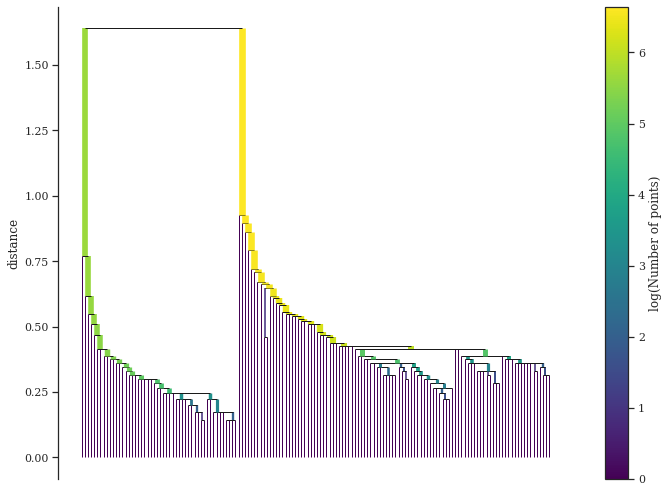

<IPython.core.display.Javascript object>

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
hdbscan_ins.single_linkage_tree_.plot(axis=ax)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "hdbscan-single-linage-tree-example.pdf"), backend="pgf"
    )
else:
    plt.show()

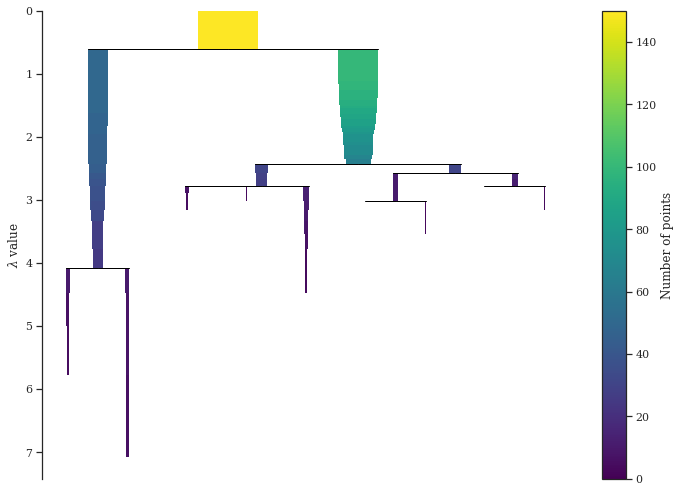

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
hdbscan_ins.condensed_tree_.plot(axis=ax, select_clusters=False)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(join(output_dir, "hdbscan-condensed-tree-example.pdf"), backend="pgf")
else:
    plt.show()

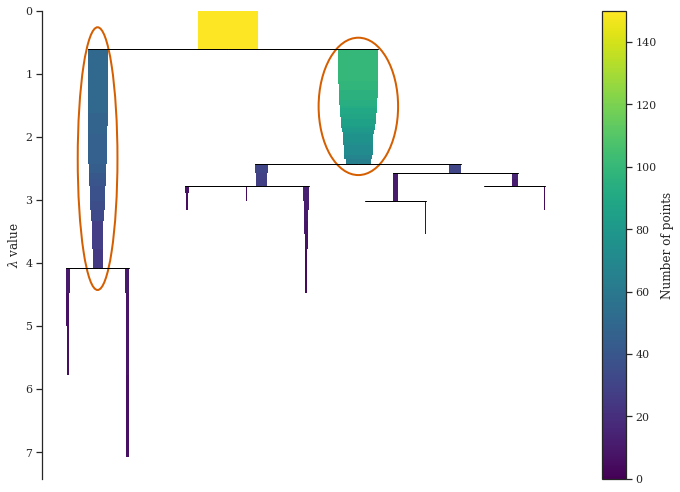

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
hdbscan_ins.condensed_tree_.plot(axis=ax, select_clusters=True)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "hdbscan-condensed-tree-final-cut-example.pdf"), backend="pgf"
    )
else:
    plt.show()

In [20]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

<IPython.core.display.Javascript object>

In [19]:
sns.color_palette("colorblind", as_cmap=True)

['#0173B2',
 '#DE8F05',
 '#029E73',
 '#D55E00',
 '#CC78BC',
 '#CA9161',
 '#FBAFE4',
 '#949494',
 '#ECE133',
 '#56B4E9']

<IPython.core.display.Javascript object>